# Setup

In [2]:
import torch

if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  running_on_colab = True
else:
  print('Not running on Colab')
  running_on_colab = False

if running_on_colab:
    print(torch.__version__)
    !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install -q git+https://github.com/snap-stanford/deepsnap.git

    from google.colab import drive
    drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/GCNN/graph_data/graphsage_prototype/'
    data_folder = filepath+"data/"
    models_folder = filepath+"models/"
    experiments_folder = filepath+"experiments/"

else:
    data_folder = "../../data/processed/graph_data_nohubs/"
    models_folder = "../../data/models/"
    experiments_folder = "../../data/experiments/"

Not running on Colab


In [3]:
import datetime
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch_sparse import matmul
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

In [4]:
import random
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

# Utility functions

In [5]:
def load_node_csv(path, index_col,type_col, **kwargs):
    """Returns node dataframe and a dict of mappings for each node type. 
    Each mapping maps from original df index to "heterodata index" { node_type : { dataframe_index : heterodata_index}}"""
    df = pd.read_csv(path, **kwargs,index_col=index_col)
    node_types = df[type_col].unique()
    mappings_dict = dict()
    for node_type in node_types:
        mapping = {index: i for i, index in enumerate(df[df[type_col] == node_type].index.unique())}
        mappings_dict[node_type] = mapping

    return df,mappings_dict

def load_edge_csv(path, src_index_col, dst_index_col, mappings, edge_type_col,src_type_col,dst_type_col, **kwargs):
    """Returns edge dataframe and a dict of edge indexes. Nodes are indexed according to the "heterodata index", using the node mappings from load_node_csv. 
    Edge indexes are tensors of shape [2, num_edges]. Dict is indexed by triplets of shape (src_type, edge_type, dst_type)."""
    df = pd.read_csv(path, **kwargs)
    df["edge_triple"] = list(zip(df[src_type_col],df[edge_type_col], df[dst_type_col]))
    edge_triplets = df["edge_triple"].unique()

    edge_index_dict = dict()
    for edge_triplet in edge_triplets:

        sub_df = df[df.edge_triple == edge_triplet]
        src_type,edge_type,dst_type = edge_triplet

        src_mapping = mappings[src_type]
        dst_mapping = mappings[dst_type]

        src = [src_mapping[index] for index in sub_df[src_index_col]]
        dst = [dst_mapping[index] for index in sub_df[dst_index_col]]
        edge_index = torch.tensor([src, dst])
        edge_index_dict[edge_triplet] = edge_index

    return df, edge_index_dict

def create_heterodata(node_map, edge_index):
    """Initializes HeteroData object from torch_geometric and creates corresponding nodes and edges, without any features"""
    data = HeteroData()
    for node_type,vals in node_map.items():
        # Initialize all node types without features
        data[node_type].num_nodes = len(vals)
    
    for edge_triplet, index in edge_index.items():
        src_type, edge_type, dst_type = edge_triplet
        data[src_type, edge_type, dst_type].edge_index = index
    
    return data

def get_reverse_types(edge_types):
    newlist = []
    for edge in edge_types:
        rev = tuple(reversed(edge))
        if rev != edge:
            if edge not in newlist:
                newlist.append(rev)
        else:
            newlist.append(rev)

    reversed_newlist = [tuple(reversed(edge)) for edge in newlist]

    return newlist, reversed_newlist

def initialize_features(data_object,feature,dim):
    for nodetype, store in data_object.node_items():
        if feature == "random":
            data_object[nodetype].x = torch.rand(store["num_nodes"],dim)
        if feature == "ones":
            data_object[nodetype].x = torch.ones(store["num_nodes"],dim)
    return data_object

# Data preparation

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data from csv and create heterodata object
node_data, node_map = load_node_csv(data_folder+"nohub_graph_nodes.csv","node_index","node_type")
edge_data, edge_index = load_edge_csv(data_folder+"nohub_graph_edge_data.csv","x_index","y_index",node_map,"edge_type","x_type","y_type")
data = create_heterodata(node_map,edge_index)

#Split the dataset
edge_types, rev_edge_types = get_reverse_types(data.edge_types)
data = initialize_features(data,"random",10)
split_transform = T.RandomLinkSplit(num_val=0.3, num_test=0.3, is_undirected=True, add_negative_train_samples=True, disjoint_train_ratio=0.2,edge_types=edge_types,rev_edge_types=rev_edge_types)
transform_dataset = T.Compose([split_transform, T.ToSparseTensor(remove_edge_index=False),T.ToDevice(device)])

train_data, val_data, test_data = transform_dataset(data)

In [7]:
data.metadata()[1]

[('disease', 'gda', 'gene_protein'),
 ('pathway', 'pathway_protein', 'gene_protein'),
 ('gene_protein', 'ppi', 'gene_protein'),
 ('gene_protein', 'gda', 'disease'),
 ('gene_protein', 'pathway_protein', 'pathway'),
 ('bert_group', 'disease_disease', 'disease'),
 ('disease', 'disease_disease', 'disease'),
 ('complex', 'form_complex', 'gene_protein'),
 ('gene_protein', 'form_complex', 'complex'),
 ('disease', 'disease_disease', 'bert_group'),
 ('bert_group', 'disease_disease', 'bert_group')]

# Model(s)

Primero voy a probar armar un hetero graph sage como el que habia hecho yo pero usando PYG (igual, con las mismas capas etc)

In [8]:
from torch_geometric.nn import SAGEConv, to_hetero

class SAGEGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels,aggr="mean"):
        super().__init__()
        self.conv1 = SAGEConv((-1,-1), hidden_channels,aggr=aggr)
        self.conv2 = SAGEConv((-1,-1), out_channels,aggr=aggr)
        self.relu = torch.nn.LeakyReLU()
        self.bn = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, x:dict, edge_index:dict):
        x = self.conv1(x, edge_index)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x

class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,edge_index,apply_sigmoid=True):
        nodes_src = x_source[edge_index[0]]
        nodes_trg = x_target[edge_index[1]]
        pred = (nodes_src * nodes_trg).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

class base_model_prototype(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels,metadata,conv_aggr="mean",hetero_aggr="mean"):
        super().__init__()
        self.encoder = SAGEGNN(hidden_channels,out_channels,aggr=conv_aggr)
        self.encoder = to_hetero(self.encoder,metadata,aggr=hetero_aggr)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
    
    def decode(self,x:dict,edge_label_index:dict,supervision_types):
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            src_type = edge_type[0]
            trg_type = edge_type[2]

            x_src = x[src_type]
            x_trg = x[trg_type]

            pred = self.decoder(x_src,x_trg,edge_index)

            pred_dict[edge_type] = pred
        
        return pred_dict
    
    def forward(self,data,supervision_types):
        x = data.x_dict
        adj_t = data.adj_t_dict
        edge_label_index = data.edge_label_index_dict

        x = self.encoder(x,adj_t)
        pred = self.decode(x,edge_label_index,supervision_types)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        num_types = len(prediction_dict.keys())
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss/num_types


In [9]:
model = base_model_prototype(32,32,data.metadata())

In [10]:
# supervision_types = [item[0] for item in train_data.edge_items() if "edge_label_index" in item[1].keys()]
supervision_types = [('gene_protein', 'gda', 'disease')]

In [11]:
model(train_data,supervision_types)

{('gene_protein',
  'gda',
  'disease'): tensor([0.4715, 0.4657, 0.4191,  ..., 0.5413, 0.5399, 0.4442],
        grad_fn=<SigmoidBackward0>)}

# Train and eval functions

In [12]:
@torch.no_grad()
def hits_at_k(y_true,x_prob,k,key) -> dict:
    """Dados los tensores x_prob y edge_label, calcula cuantas predicciones hizo correctamente en los primeros k puntajes.
    x_prob es la predicción del modelo luego de aplicar sigmoid (sin redondear, osea, el puntaje crudo)"""

    #ordeno los puntajes de mayor a menor
    x_prob, indices = torch.sort(x_prob, descending=True)

    #me quedo solo con los k mayor punteados
    x_prob = x_prob[:k]
    indices = indices[:k]

    if any(x_prob < 0.5):
      threshold_index = (x_prob < 0.5).nonzero()[0].item()
      print(f"Top {k} scores for {key} below classification threshold 0.5, threshold index: {threshold_index}")

    #busco que label tenían esas k preds
    labels = y_true[indices]

    #cuento cuantas veces predije uno positivo en el top k
    hits = labels.sum().item()

    return hits

def train(model, optimizer, graph,supervision_types):
    model.train()
    optimizer.zero_grad()
    preds = model(graph,supervision_types)
    edge_label = graph.edge_label_dict
    loss = model.loss(preds, edge_label)
    loss.backward()
    optimizer.step()

    return loss.item()

def get_metrics(y_true, x_pred):
   acc = round(accuracy_score(y_true,x_pred),2)
   ap = round(average_precision_score(y_true, x_pred),2)
   roc_auc = round(roc_auc_score(y_true,x_pred),2)

   return acc,ap ,roc_auc
  

@torch.no_grad()
def test(model,data,supervision_types,metric):
  model.eval()
  preds = model(data,supervision_types)
  edge_label = data.edge_label_dict
  all_preds = []
  all_true = []
  for key,pred in preds.items():
      pred_label = torch.round(pred)
      ground_truth = edge_label[key]
      all_preds.append(pred_label)
      all_true.append(ground_truth)
  total_predictions = torch.cat(all_preds, dim=0).cpu().numpy()
  total_true = torch.cat(all_true, dim=0).cpu().numpy()
  score = metric(total_true,total_predictions)
  return score
  

@torch.no_grad()
def full_test(model,data,supervision_types,k,global_score=True):
  model.eval()
  preds = model(data,supervision_types)
  edge_label = data.edge_label_dict
  metrics = {}

  if global_score:
    all_scores = []
    all_preds = []
    all_true = []
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        all_scores.append(pred)
        all_preds.append(pred_label)
        all_true.append(ground_truth)

    total_predictions = torch.cat(all_preds, dim=0)
    total_true = torch.cat(all_true, dim=0)
    total_scores = torch.cat(all_scores,dim=0)

    acc, ap, roc_auc =  get_metrics(total_true.cpu().numpy(), total_predictions.cpu().numpy())
    hits_k = hits_at_k(total_true,total_scores,k,"all")
    metrics["all"] = [acc,ap,roc_auc,hits_k]

  else:
    for key,pred in preds.items():
        pred_label = torch.round(pred)
        ground_truth = edge_label[key]
        acc, ap, roc_auc = get_metrics(ground_truth.cpu().numpy(), pred_label.cpu().numpy())
        hits_k = hits_at_k(ground_truth,pred,k,key)
        metrics[key] = [acc,ap, roc_auc,hits_k]
  
  return metrics

In [13]:
def plot_training_stats(title, losses, train_metric,val_metric,metric_str):

  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(val_metric, "r-", label=f"val {metric_str}")
  p3, = ax2.plot(train_metric, "o-", label=f"train {metric_str}")
  plt.legend(handles=[p1, p2, p3])
  plt.show()

In [14]:
args = {
    'hidden_size': 32,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs':50,
}

model = base_model_prototype(args["hidden_size"],args["hidden_size"],data.metadata()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

0.7163828611373901
0.4102250039577484
0.366863489151001
0.32605746388435364
0.285045862197876


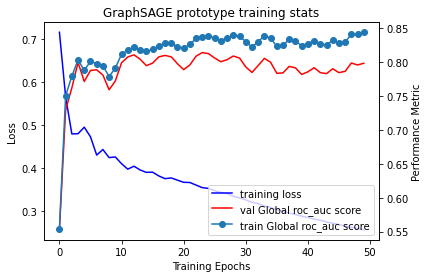

In [15]:
losses = []
train_scores = []
val_scores = []
metric = roc_auc_score
metric_name = "Global roc_auc score"
epochs = 50

for epoch in range(epochs):
    loss = train(model,optimizer,train_data,supervision_types)
    train_score = test(model,train_data,supervision_types,metric)
    val_score = test(model,val_data,supervision_types,metric)
    losses.append(loss)
    train_scores.append(train_score)
    val_scores.append(val_score)

    if epoch%10 == 0:
        print(loss)

plot_training_stats("GraphSAGE prototype training stats",losses,train_scores,val_scores,metric_name)

In [16]:
test(model,val_data,supervision_types,average_precision_score)

0.7233883235389867

In [17]:
val_data.edge_label_dict[supervision_types[0]]

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [18]:
model(val_data,supervision_types)

{('gene_protein',
  'gda',
  'disease'): tensor([0.9964, 0.9785, 0.9984,  ..., 0.0569, 0.1342, 0.2447],
        grad_fn=<SigmoidBackward0>)}

In [19]:
full_test(model,val_data,supervision_types,2000)

{'all': [0.8, 0.72, 0.8, 1896.0]}

# Flexible Models

Voy a tratar de armar una base_model class donde pueda elegir y cambiar las partes, para seguir los guidelines del paper de graphgym

In [56]:
from torch_geometric.nn import to_hetero

class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,edge_index,apply_sigmoid=True):
        nodes_src = x_source[edge_index[0]]
        nodes_trg = x_target[edge_index[1]]
        pred = (nodes_src * nodes_trg).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

class base_message_layer(torch.nn.Module):

    def __init__(self, intra_layer_args,hidden_layer=True):
        super().__init__()

        # Currently SageConv or GATConv, might have to modify this to support other Convs
        conv_type = intra_layer_args["conv_type"]
        self.conv = conv_type((-1,-1), intra_layer_args["hidden_channels"],aggr=intra_layer_args["micro_aggregation"],add_self_loops=False)
        self.normalize = intra_layer_args["L2_norm"]

        post_conv_modules = []
        if intra_layer_args["batch_norm"]:
            bn = torch.nn.BatchNorm1d(intra_layer_args["hidden_channels"])
            post_conv_modules.append(bn)
        
        if intra_layer_args["dropout"] > 0:    
            dropout = torch.nn.Dropout(p=intra_layer_args["dropout"])
            post_conv_modules.append(dropout)
        
        # No activation on final embedding layer
        if hidden_layer:
            activation = intra_layer_args["activation"]()
            post_conv_modules.append(activation)
        
        self.post_conv = torch.nn.Sequential(*post_conv_modules)

    def forward(self, x:dict, edge_index:dict) -> dict:
        x = self.conv(x,edge_index)
        x = self.post_conv(x)
        if self.normalize:
            x = torch.nn.functional.normalize(x,2,-1)
        return x

class multilayer_message_passing(torch.nn.Module):
    #TODO: consider input and output dims with skipcat. Currently the two supported convs auto-detect dimensions. Might have to modify this if i add more convs in the future.
    def __init__(self,num_layers,intra_layer_args,metadata):
        super().__init__()

        self.skip = intra_layer_args["layer_connectivity"]
        self.num_layers = num_layers

        for i in range(self.num_layers):
            hidden_layer = i != self.num_layers-1
            layer = to_hetero(base_message_layer(intra_layer_args,hidden_layer),metadata,intra_layer_args["macro_aggregation"])
            self.add_module(f"Layer_{i}",layer)
    
    def hetero_skipsum(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = x_val + x_i_val
            x_transformed[key] = transformed_val

        return x_transformed

    def hetero_skipcat(self,x: dict, x_i:dict) -> dict:
        x_transformed = {}
        for key,x_val in x.items():
            x_i_val = x_i[key]
            transformed_val = torch.cat([x_val,x_i_val],dim=-1)
            x_transformed[key] = transformed_val

        return x_transformed
    
    def forward(self, x:dict, edge_index:dict) -> dict:
        #TODO: add L2 norm option
        for i, layer in enumerate(self.children()):
            x_i = x
            x = layer(x,edge_index)
            if self.skip == "skipsum":
                x = self.hetero_skipsum(x,x_i)
            elif self.skip == "skipcat" and i < self.num_layers -1:
                x = self.hetero_skipcat(x,x_i)
        
        return x 

class MLP(torch.nn.Module):
    def __init__(self,num_layers,in_dim,out_dim,intra_layer_args,hidden_dim=None):
        super().__init__()

        hidden_dim = out_dim if hidden_dim is None else hidden_dim

        modules = []
        if num_layers == 1:
            modules.append(torch.nn.Linear(in_dim,out_dim))
        else:
            for i in range(num_layers):
                final_layer = i == num_layers-1
                first_layer = i == 0
                if first_layer:
                    modules.append(torch.nn.Linear(in_dim,hidden_dim))
                    modules.append(intra_layer_args["activation"]())
                elif final_layer:
                    modules.append(torch.nn.Linear(hidden_dim,out_dim))
                else:
                    modules.append(torch.nn.Linear(hidden_dim,hidden_dim))
                    modules.append(intra_layer_args["activation"]())
        
        self.model = torch.nn.Sequential(*modules)
    
    def forward(self,x):
        x = self.model(x)
        return x

class base_encoder(torch.nn.Module):
    def __init__(self,inter_layer_args,intra_layer_args,metadata):
        super().__init__()

        self.has_pre_mlp = inter_layer_args["pre_process_layers"] > 0
        self.has_post_mlp = inter_layer_args["post_process_layers"] > 0

        if self.has_pre_mlp:
            self.pre_mlp = to_hetero(MLP(inter_layer_args["pre_process_layers"],inter_layer_args["feature_dim"],intra_layer_args["hidden_channels"],intra_layer_args),metadata)
        
        self.message_passing = multilayer_message_passing(inter_layer_args["msg_passing_layers"],intra_layer_args,metadata)

        if self.has_post_mlp:
            self.post_mlp = to_hetero(MLP(inter_layer_args["post_process_layers"],intra_layer_args["hidden_channels"],intra_layer_args["hidden_channels"],intra_layer_args),metadata)
    
    def forward(self,x:dict,edge_index:dict) -> dict :
        if self.has_pre_mlp:
            x = self.pre_mlp(x)

        x = self.message_passing(x,edge_index)
        
        if self.has_post_mlp:
            x = self.post_mlp(x)

        return x

class base_model(torch.nn.Module):
    def __init__(self, inter_layer_args, intra_layer_args,metadata):
        super().__init__()

        inter_default = {
        "feature_dim": 10,
        "pre_process_layers":0,
        "msg_passing_layers":2,
        "post_process_layers":0,
        }

        intra_default = {
            "conv_type":SAGEConv,
            "hidden_channels": 32,
            "batch_norm": True,
            "dropout":0,
            "activation":torch.nn.LeakyReLU,
            "micro_aggregation":"mean",
            "macro_aggregation":"mean",
            "layer_connectivity":None
        }

        for arg in inter_default:
            if arg not in inter_layer_args:
                inter_layer_args[arg] = inter_default[arg]

        for arg in intra_default:
            if arg not in intra_layer_args:
                intra_layer_args[arg] = intra_default[arg]
        
        
        self.encoder = base_encoder(inter_layer_args,intra_layer_args,metadata)
        self.decoder = inner_product_decoder()
        self.loss_fn = torch.nn.BCELoss()
    
    def decode(self,x:dict,edge_label_index:dict,supervision_types):
        pred_dict = {}
        for edge_type in supervision_types:
            edge_index = edge_label_index[edge_type]

            src_type = edge_type[0]
            trg_type = edge_type[2]

            x_src = x[src_type]
            x_trg = x[trg_type]

            pred = self.decoder(x_src,x_trg,edge_index)

            pred_dict[edge_type] = pred
        
        return pred_dict
    
    def forward(self,data,supervision_types):
        x = data.x_dict
        adj_t = data.adj_t_dict
        edge_label_index = data.edge_label_index_dict

        x = self.encoder(x,adj_t)
        pred = self.decode(x,edge_label_index,supervision_types)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        num_types = len(prediction_dict.keys())
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss/num_types

In [98]:
# Supported conv types so far: SAGEConv, GATConv
# Currently supported conv types also support Sparse Tensor adj_t
# GCN is not supported for bipartite graphs, may add support for RGCN in the future

from torch_geometric.nn import SAGEConv, GATConv

intra_default = {
    "hidden_channels":32,
    "conv_type":SAGEConv,
    "batch_norm": True,
    "dropout":0.1,
    "activation":torch.nn.LeakyReLU,
    "micro_aggregation":"mean",
    "macro_aggregation":"sum",
    "layer_connectivity":"skipcat",
    "L2_norm":True
}

inter_default = {
"feature_dim": 10,
"pre_process_layers":1,
"msg_passing_layers":3,
"post_process_layers":2,
}

training_args = {
    'weight_decay': 1e-3,
    'lr': 0.001,
    'epochs':400,
}

model = base_model(inter_default,intra_default,train_data.metadata())

0.6918583512306213
0.6243839263916016
0.5440958142280579
0.47676533460617065
0.4359716475009918
0.4037325382232666
0.3686058521270752
0.3318670690059662
0.2965227961540222
0.2647138833999634
0.23672334849834442
0.2131378948688507
0.19723671674728394
0.18453830480575562
0.16884443163871765
0.16146054863929749
0.1528165638446808
0.14526118338108063
0.14630776643753052
0.13477949798107147
0.1270083636045456
0.1245458647608757
0.12246043980121613
0.12009605765342712
0.11411780118942261
0.10801678150892258
0.11337865889072418
0.10483855754137039
0.10393241047859192
0.10497087985277176
0.09908946603536606
0.0974249616265297
0.09457160532474518
0.09357777237892151
0.09102238714694977
0.08899922668933868
0.0883842334151268
0.08818888664245605
0.09162122756242752
0.08745452761650085


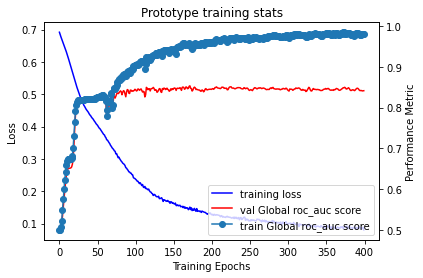

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=training_args['lr'], weight_decay=training_args['weight_decay'])
losses = []
train_scores = []
val_scores = []
metric = roc_auc_score
metric_name = "Global roc_auc score"
epochs = training_args["epochs"]

for epoch in range(epochs):
    loss = train(model,optimizer,train_data,supervision_types)
    train_score = test(model,train_data,supervision_types,metric)
    val_score = test(model,val_data,supervision_types,metric)
    losses.append(loss)
    train_scores.append(train_score)
    val_scores.append(val_score)

    if epoch%10 == 0:
        print(loss)

plot_training_stats("Prototype training stats",losses,train_scores,val_scores,metric_name)


In [100]:
full_test(model,val_data,supervision_types,2000)

{'all': [0.84, 0.78, 0.84, 1952.0]}

In [78]:
model

base_model(
  (encoder): base_encoder(
    (pre_mlp): GraphModule(
      (model): ModuleList(
        (0): ModuleDict(
          (gene_protein): Linear(in_features=10, out_features=32, bias=True)
          (disease): Linear(in_features=10, out_features=32, bias=True)
          (pathway): Linear(in_features=10, out_features=32, bias=True)
          (complex): Linear(in_features=10, out_features=32, bias=True)
          (bert_group): Linear(in_features=10, out_features=32, bias=True)
        )
      )
    )
    (message_passing): multilayer_message_passing_with_skip(
      (Layer_0): GraphModule(
        (conv): ModuleDict(
          (disease__gda__gene_protein): SAGEConv((-1, -1), 32, aggr=mean)
          (pathway__pathway_protein__gene_protein): SAGEConv((-1, -1), 32, aggr=mean)
          (gene_protein__ppi__gene_protein): SAGEConv((-1, -1), 32, aggr=mean)
          (gene_protein__gda__disease): SAGEConv((-1, -1), 32, aggr=mean)
          (gene_protein__pathway_protein__pathway): SAGEC